# Profit prediction using Arima,Sarima,LSTM (A comparision)
Research paper - https://ieeexplore.ieee.org/document/9964190 

dataset(2m) - https://excelbianalytics.com/wp/downloads-18-sample-csv-files-data-sets-for-testing-sales/

Necessery libraries

In [15]:
# !pip install pandas matplotlib seaborn numpy torch

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim

In [2]:
sales_data = pd.read_csv('Data\sales_data.csv')

In [4]:
sales_data.head(10)

,Region,Country,Item Type,Sales Channel,Order Priority,Order Date,Order ID,Ship Date,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit,year
607401,Central America and the Caribbean,Cuba,Fruits,Online,L,2010-01-01,978111779,1/2/2010,3866,9.33,6.92,36069.78,26752.72,9317.06,2010
1528517,Middle East and North Africa,Iraq,Household,Offline,M,2010-01-01,899159562,1/29/2010,151,668.27,502.54,100908.77,75883.54,25025.23,2010
221606,Europe,Germany,Snacks,Online,M,2010-01-01,936589038,2/10/2010,6364,152.58,97.44,971019.12,620108.16,350910.96,2010
707933,Asia,Turkmenistan,Office Supplies,Online,M,2010-01-01,192446839,1/14/2010,8151,651.21,524.96,5308012.71,4278948.96,1029063.75,2010
835978,Central America and the Caribbean,Dominica,Snacks,Online,C,2010-01-01,649669063,2/6/2010,368,152.58,97.44,56149.44,35857.92,20291.52,2010
1377570,Europe,Macedonia,Fruits,Online,C,2010-01-01,899041545,1/3/2010,5227,9.33,6.92,48767.91,36170.84,12597.07,2010
1314051,Sub-Saharan Africa,Senegal,Vegetables,Online,H,2010-01-01,585279309,2/2/2010,6009,154.06,90.93,925746.54,546398.37,379348.17,2010
1184089,Europe,Malta,Household,Online,M,2010-01-01,942728936,1/14/2010,3297,668.27,502.54,2203286.19,1656874.38,546411.81,2010
1207464,Europe,Liechtenstein,Cereal,Online,L,2010-01-01,940682303,2/9/2010,7652,205.70,117.11,1574016.40,896125.72,677890.68,2010
836721,Sub-Saharan Africa,Republic of the Congo,Clothes,Offline,H,2010-01-01,967760598,1/5/2010,722,109.28,35.84,78900.16,25876.48,53023.68,2010


Dataset processing

In [3]:
sales_data['Order Date'] = pd.to_datetime(sales_data['Order Date'], format='%m/%d/%Y')
sales_data['year'] = sales_data['Order Date'].dt.year
sales_data = sales_data.sort_values(by='Order Date')

Dataset information

In [5]:
sales_data.info()
sales_data.describe()
#-- check for missing values --
print(sales_data.isna().sum())
sales_data['Item Type'].value_counts()
sales_data['Sales Channel'].value_counts()
sales_data['year'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 2000000 entries, 607401 to 480712
Data columns (total 15 columns):
 #   Column          Dtype         
---  ------          -----         
 0   Region          object        
 1   Country         object        
 2   Item Type       object        
 3   Sales Channel   object        
 4   Order Priority  object        
 5   Order Date      datetime64[ns]
 6   Order ID        int64         
 7   Ship Date       object        
 8   Units Sold      int64         
 9   Unit Price      float64       
 10  Unit Cost       float64       
 11  Total Revenue   float64       
 12  Total Cost      float64       
 13  Total Profit    float64       
 14  year            int32         
dtypes: datetime64[ns](1), float64(5), int32(1), int64(2), object(6)
memory usage: 236.5+ MB
Region            0
Country           0
Item Type         0
Sales Channel     0
Order Priority    0
Order Date        0
Order ID          0
Ship Date         0
Units Sold        0
Uni

year
2014    187542
2010    187357
2018    187277
2011    187209
2017    187118
2015    186906
2012    186842
2016    186766
2013    186753
2019    186426
2020    129804
Name: count, dtype: int64

Dataset processing

Visualization

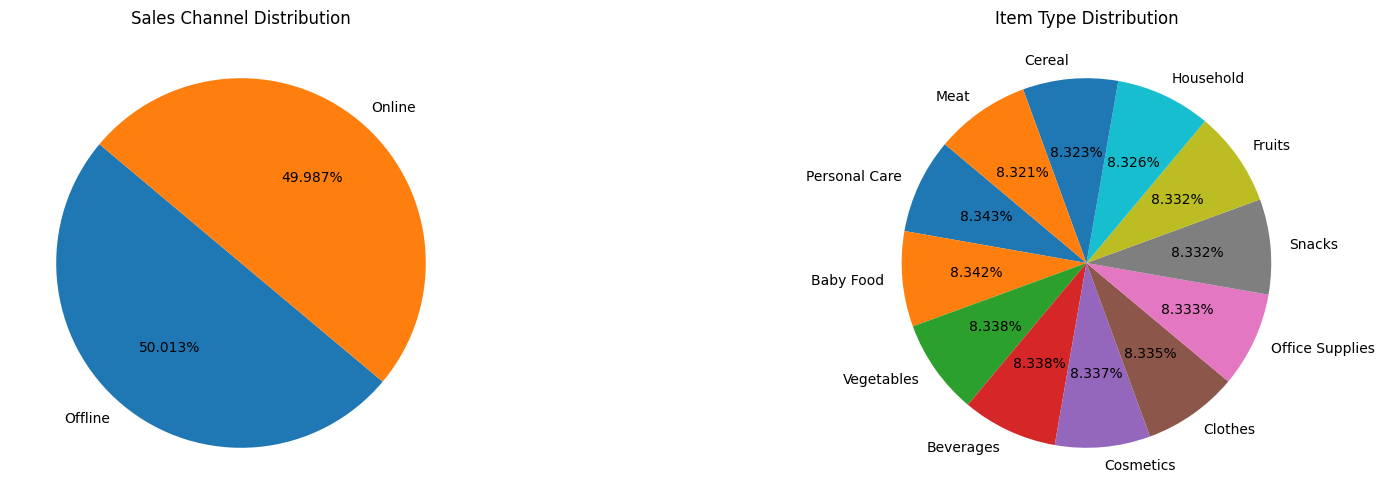

In [6]:
offline_sales = sales_data[sales_data['Sales Channel'] == 'Offline']
online_sales = sales_data[sales_data['Sales Channel'] == 'Online']
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.pie([len(offline_sales),len(online_sales)],labels=['Offline','Online'],autopct='%1.3f%%',startangle=140)
plt.title('Sales Channel Distribution')
plt.subplot(1,2,2)
plt.pie(sales_data['Item Type'].value_counts(),labels=sales_data['Item Type'].value_counts().index,autopct='%1.3f%%',startangle=140)
plt.title('Item Type Distribution')
plt.show()